# Homework Starter — Stage 10b: Time Series & Classification
Fill in the TODOs. Use your own dataset or adapt the synthetic generator below.

In [1]:
# Imports
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, TimeSeriesSplit
np.random.seed(7); sns.set(); plt.rcParams['figure.figsize']=(9,4)

## Option A: Use Your Own Data (Recommended)
Load your data here (ensure a DateTime index for time series).

# Download Data

In [9]:
# Imports
import os
from pathlib import Path
import numpy as np
import pandas as pd
import yfinance as yf

# 1) Download a single asset price series (you can change the ticker)
ticker = "AAPL"
data = yf.download(ticker, start="2021-01-01", end="2023-01-01")

# Handle Close price robustly (yfinance recently changed defaults)
if isinstance(data.columns, pd.MultiIndex):
    price = data['Close'][ticker].rename('price')
else:
    price = data['Close'].rename('price')

# 2) Build returns (same columns as synthetic generator style)
df = pd.DataFrame({'price': price})
df['ret'] = df['price'].pct_change().fillna(0.0)
df['log_ret'] = np.log1p(df['ret'])  # log(1 + ret)

# 3) Save to disk
save_dir = Path("/Users/seanice/Desktop/Bootcamp/bootcamp_Linxi_Pan/homework/homework10")
save_dir.mkdir(parents=True, exist_ok=True)
csv_path = save_dir / "aapl_timeseries.csv"
df.to_csv(csv_path, index=True)
print(f"Saved base data to: {csv_path}")

df.head()

/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_23817/2672180260.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2021-01-01", end="2023-01-01")
[*********************100%***********************]  1 of 1 completed

Saved base data to: /Users/seanice/Desktop/Bootcamp/bootcamp_Linxi_Pan/homework/homework10/aapl_timeseries.csv


,price,ret,log_ret
Date,,,
2021-01-04,126.096581,0.000000,0.000000
2021-01-05,127.655609,0.012364,0.012288
2021-01-06,123.358528,-0.033662,-0.034241
2021-01-07,127.567932,0.034123,0.033554
2021-01-08,128.669006,0.008631,0.008594


# Feature Engineering

In [10]:
# === Feature Engineering (no look-ahead) ===
# lag-1 return (yesterday's return)
df['lag_1'] = df['ret'].shift(1)

# 5-day rolling mean of returns (shift by 1 to avoid leakage)
df['roll_mean_5'] = df['ret'].rolling(5).mean().shift(1)

# (Optional) rolling volatility example – keep commented if you only need two features
# df['roll_vol_20'] = df['ret'].rolling(20).std().shift(1)

# === Targets ===
# Next-period return (for regression track, if you want)
df['y_next_ret'] = df['ret'].shift(-1)

# Up/Down label for classification: next return > 0 => 1 else 0
df['y_up'] = (df['y_next_ret'] > 0).astype(int)

# Drop rows with NaNs created by lag/rolling/shift
df_feat = df.dropna().copy()
df_feat.head()


,price,ret,log_ret,lag_1,roll_mean_5,y_next_ret,y_up
Date,,,,,,,
2021-01-11,125.677574,-0.023249,-0.023524,0.008631,0.004291,-0.001396,0
2021-01-12,125.502190,-0.001396,-0.001396,-0.023249,-0.000358,0.016227,1
2021-01-13,127.538712,0.016227,0.016097,-0.001396,-0.003110,-0.015127,0
2021-01-14,125.609390,-0.015127,-0.015243,0.016227,0.006867,-0.013731,0
2021-01-15,123.884705,-0.013731,-0.013826,-0.015127,-0.002983,0.005427,1


# Split

In [11]:
# Time-aware split (80/20)
cut = int(len(df_feat) * 0.8)
train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]

# Choose features (extend if you add more)
features = ['lag_1', 'roll_mean_5']   # add 'roll_vol_20' if you created it

# Build X/y for regression and classification
X_tr, X_te = train[features], test[features]
y_tr_reg, y_te_reg = train['y_next_ret'], test['y_next_ret']  # (optional track)
y_tr_clf, y_te_clf = train['y_up'],       test['y_up']        # classification track

len(X_tr), len(X_te), y_tr_clf.mean()  # quick sanity check

(397, 100, 0.5163727959697733)

# Pipeline + Model

Accuracy: 0.5
              precision    recall  f1-score   support

           0       0.64      0.25      0.36        56
           1       0.46      0.82      0.59        44

    accuracy                           0.50       100
   macro avg       0.55      0.53      0.47       100
weighted avg       0.56      0.50      0.46       100



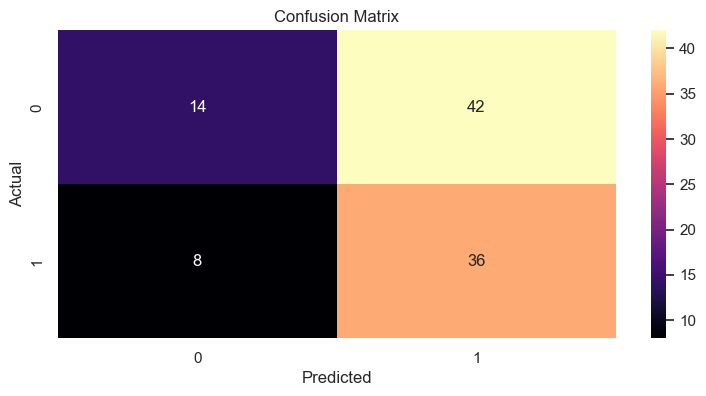

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Track 2: Classification (up/down)
clf = Pipeline([
    ('scaler', StandardScaler()),
    ('logit',  LogisticRegression(max_iter=1000, n_jobs=None))
])

clf.fit(X_tr, y_tr_clf)
predc = clf.predict(X_te)

print("Accuracy:", accuracy_score(y_te_clf, predc))
print(classification_report(y_te_clf, predc, digits=2))

cm = confusion_matrix(y_te_clf, predc)
sns.heatmap(cm, annot=True, fmt='d', cmap='magma')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## Option B: Synthetic Generator (Use if you don't have data ready)

In [3]:
# Synthetic series with regimes & jumps
n=500
dates=pd.bdate_range('2021-01-01', periods=n)
mu = np.where(np.arange(n)<n//2, 0.0003, -0.0001)
sigma = np.where(np.arange(n)<n//2, 0.01, 0.015)
eps = np.random.normal(mu, sigma)
jumps = np.zeros(n); jump_days = np.random.choice(np.arange(20,n-20), size=5, replace=False)
jumps[jump_days] = np.random.normal(0,0.05,size=len(jump_days))
rets = eps + jumps
price = 100*np.exp(np.cumsum(rets))
df = pd.DataFrame({'price':price}, index=dates)
df['ret'] = df['price'].pct_change().fillna(0.0)
df['log_ret'] = np.log1p(df['ret'])
df.head()

,price,ret,log_ret
2021-01-01,101.735412,0.000000,0.000000
2021-01-04,101.292875,-0.004350,-0.004359
2021-01-05,101.356527,0.000628,0.000628
2021-01-06,101.800950,0.004385,0.004375
2021-01-07,101.031283,-0.007561,-0.007589


## Feature Engineering

In [8]:
# TODO: create at least two features
df['lag_1'] = df['ret'].shift(1)
df['roll_mean_5'] = df['ret'].rolling(5).mean().shift(1)
# Add your own:
df['roll_vol_20'] = df['ret'].rolling(20).std().shift(1)
df['y_next_ret'] = df['ret'].shift(-1)
df['y_up'] = (df['y_next_ret']>0).astype(int)
df_feat = df.dropna().copy()
df_feat.head()

,price,ret,log_ret,lag_1,roll_mean_5,y_next_ret,y_up,roll_vol_20
2021-01-29,100.198878,0.016949,0.016807,-0.014854,-0.003707,0.001845,1,0.007370
2021-02-01,100.383751,0.001845,0.001843,0.016949,0.002509,-0.003565,0,0.008455
2021-02-02,100.025880,-0.003565,-0.003571,0.001845,0.001706,0.020804,1,0.008429
2021-02-03,102.106835,0.020804,0.020591,-0.003565,0.000685,-0.000154,0,0.008453
2021-02-04,102.091126,-0.000154,-0.000154,0.020804,0.004236,-0.014106,0,0.009675


## Split

In [5]:
# Time-aware split
cut=int(len(df_feat)*0.8)
train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]
features=['lag_1','roll_mean_5']  # extend as you add features
X_tr, X_te = train[features], test[features]
y_tr_reg, y_te_reg = train['y_next_ret'], test['y_next_ret']
y_tr_clf, y_te_clf = train['y_up'], test['y_up']

## Pipeline + Model (Choose one track below)

In [6]:
# Track 1: Forecasting returns
reg = Pipeline([('scaler', StandardScaler()), ('linreg', LinearRegression())])
reg.fit(X_tr, y_tr_reg)
pred = reg.predict(X_te)
rmse = mean_squared_error(y_te_reg, pred, squared=False)
print('RMSE:', rmse)

RMSE: 0.014524324812974158


/opt/anaconda3/envs/bootcamp_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.55      0.72      0.62        54
           1       0.46      0.29      0.36        45

    accuracy                           0.53        99
   macro avg       0.51      0.51      0.49        99
weighted avg       0.51      0.53      0.50        99



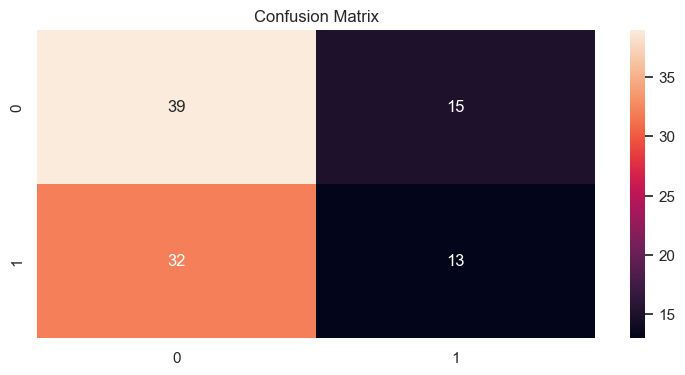

In [7]:
# Track 2: Classification (up/down)
clf = Pipeline([('scaler', StandardScaler()), ('logit', LogisticRegression(max_iter=1000))])
clf.fit(X_tr, y_tr_clf)
predc = clf.predict(X_te)
print(classification_report(y_te_clf, predc))
cm = confusion_matrix(y_te_clf, predc)
sns.heatmap(cm, annot=True, fmt='d'); plt.title('Confusion Matrix'); plt.show()

## Interpretation (Markdown)
- What worked?
- Where might assumptions fail?
- How would you extend features or model?

### Save Notebook
Remember to save as `notebooks/modeling_<team>.ipynb`.